**Описание проекта:**  
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.  Удовлетворённость работой напрямую влияет на отток сотрудников.  
Даны следующие таблицы: train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate, train_quit, test_target_quit.

**Цель проекта:**  
Разработать рекомендации на основе модели машинного обучения, которые позволят избежать финансовых потерь в связи с оттоком сотрудников.  

**Задачи проекта:**  
 Задача 1 — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  
 Задача 2 — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.  

### **Задача: предсказание уровня удовлетворённости сотрудника**

#### **Шаг: Загрузка данных**

In [1]:
!pip install matplotlib==3.5.0 -q

!pip install shap==0.40.0 -q

!pip install phik==0.11.1 -q

!pip install -Uq scikit-learn

!pip install mlxtend -q

!pip install phik==0.11.1 -q


In [2]:
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

import warnings 
import phik
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.metrics import roc_auc_score,f1_score

# загрузите нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer)
import shap
from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, make_scorer


from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt


from mlxtend.plotting import plot_decision_regions 
import phik

In [3]:
train_job_satisfaction_rate=pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В данных есть пропуски, решим как их обработать на следующем шаге.

In [5]:
test_features=pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
test_target_job_satisfaction_rate=pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [9]:
train_quit=pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [10]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [11]:
test_target_quit=pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [12]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [13]:
train_job_satisfaction_rate_first=train_job_satisfaction_rate.copy()
test_features_first=test_features.copy()
test_target_job_satisfaction_rate_first=test_target_job_satisfaction_rate.copy()
train_quit_first=train_quit.copy()
test_target_quit_first=test_target_quit.copy()

**Данные загружены и проверены на предмет соответствия описаниям. Названия колонок соответствуют стандартами оформления. Форматы колонок корректны.**

#### **Шаг: Предобработка данных**

Проверим данные на наличие пропусков и дубликатов.

In [14]:
train_job_satisfaction_rate.duplicated().sum()

0

In [15]:
test_features.duplicated().sum()

0

In [16]:
test_target_job_satisfaction_rate.duplicated().sum()

0

In [17]:
train_quit.duplicated().sum()

0

In [18]:
test_target_quit.duplicated().sum()

0

Явных дубликатов не выявлено.

In [19]:
display(train_job_satisfaction_rate.isna().sum())

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Проверим содержание категорийных признаков.

In [20]:
cat_col_names=train_job_satisfaction_rate.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print('train_job_satisfaction_rate')
    print(i)
    print(train_job_satisfaction_rate[i].unique())
    print()
    
cat_col_names=test_features.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print('test_features')
    print(i)
    print(test_features[i].unique())
    print()
    
cat_col_names=test_target_job_satisfaction_rate.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print('test_target_job_satisfaction_rate')
    print(i)
    print(test_target_job_satisfaction_rate[i].unique())
    print()
    
cat_col_names=train_quit.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print('train_quit')
    print(i)
    print(train_quit[i].unique())
    print()
        
cat_col_names=test_target_quit.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print('test_target_quit')
    print(i)
    print(test_target_quit[i].unique())
    print()

train_job_satisfaction_rate
dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

train_job_satisfaction_rate
level
['junior' 'middle' 'sinior' nan]

train_job_satisfaction_rate
workload
['medium' 'high' 'low']

train_job_satisfaction_rate
last_year_promo
['no' 'yes']

train_job_satisfaction_rate
last_year_violations
['no' 'yes']

test_features
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

test_features
level
['junior' 'middle' 'sinior' nan]

test_features
workload
['medium' 'low' 'high' ' ']

test_features
last_year_promo
['no' 'yes']

test_features
last_year_violations
['no' 'yes']

train_quit
dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']

train_quit
level
['middle' 'junior' 'sinior']

train_quit
workload
['high' 'medium' 'low']

train_quit
last_year_promo
['no' 'yes']

train_quit
last_year_violations
['no' 'yes']

train_quit
quit
['no' 'yes']

test_target_quit
quit
['yes' 'no']



В test_features есть неявные пропуски- непустые значения с символами.

В дальнейшем перенесем замену пропусков в пайплайн.

**По итогам предобработки были выявлены пропуски и неявные ипропуски в виде пробела в значении колонки dept в test_features
 . При написании пайплайна учтем эти проблемы  данных.**

#### **Исследовательский анализ данных**

Изучим данные тренировочного датасета.

In [21]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


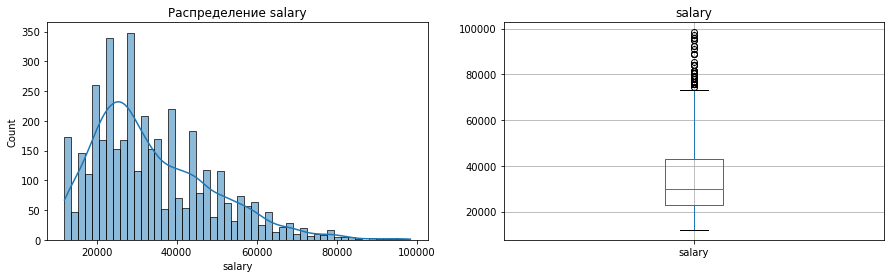

Среднее значение salary -  33926.7


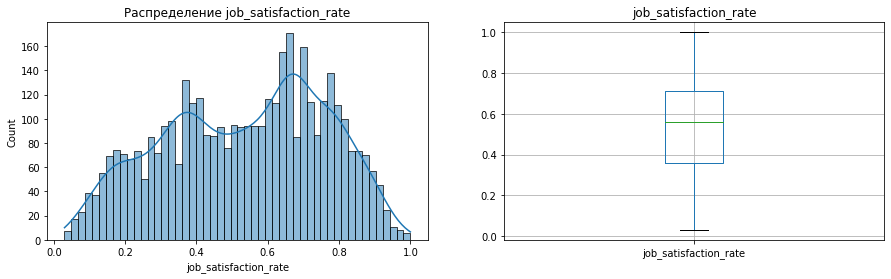

Среднее значение job_satisfaction_rate -  0.5339950000000001


In [22]:
cat_col_names=train_job_satisfaction_rate.select_dtypes(include='number').drop(['id','supervisor_evaluation','employment_years'],axis=1).columns.tolist()

for i in cat_col_names:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sb.histplot(data=train_job_satisfaction_rate, x=i, bins=50, kde=True, ax=axs[0])
    train_job_satisfaction_rate[[i]].boxplot(ax=axs[1])
    axs[0].set_title(f'Распределение {i}') 
    axs[1].set_title(f'{i}') 
    plt.show()
    print(f"Среднее значение {i} - ",train_job_satisfaction_rate[i].mean())

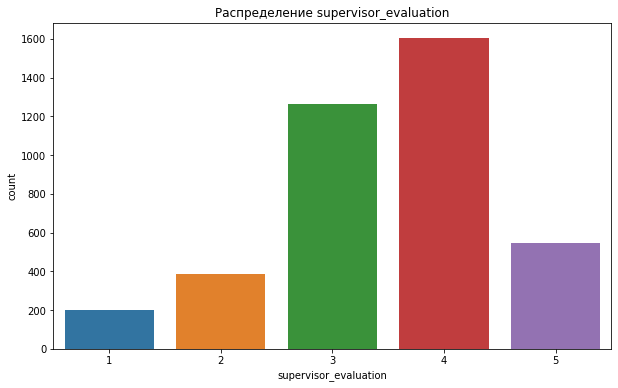

Среднее значение -  3.4765


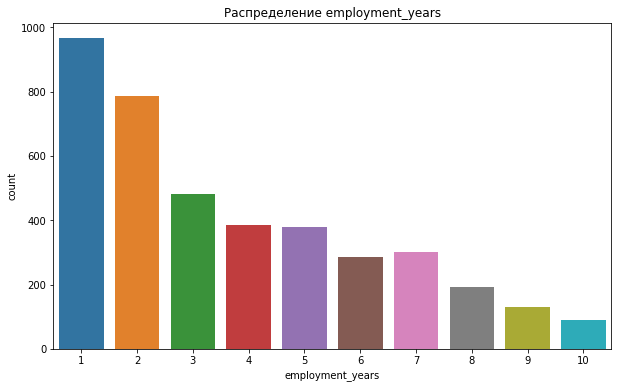

Среднее значение -  3.7185


In [70]:
cat_col_names = train_job_satisfaction_rate[['supervisor_evaluation', 'employment_years']].columns.tolist()

for i in cat_col_names:
    sb.countplot(x=train_job_satisfaction_rate[i])
    plt.title(f'Распределение {i}')
    plt.show()
    print(f"Среднее значение - ", train_job_satisfaction_rate[i].mean())


Средний срок работы в компании - 3,7 лет. При этом половина сотрудников проработали менее 3 лет. Вторая часть сотрудников проработали от 3 до 6 лет. Остальные сотрудники, проработавшие более 6 лет -это редкие исключения. Большинство сотрудников имеют оценку руководителя 4 балла. Средняя зарплата сотрудников - 34 у.е., но имеются исключения в большую сторону. Удовлетворенность работой в среднем 0.5 из 1. При этом имеются 2 пика - 0.4 и 0.7, т.е есть те ,что удовлетворен работой выше среднего и ниже среднего.

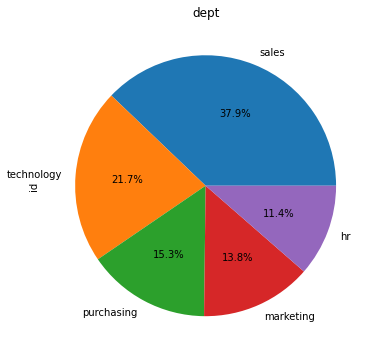

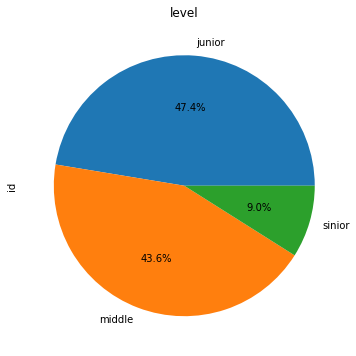

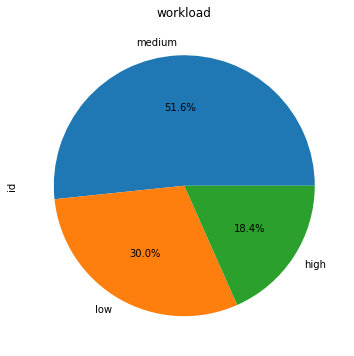

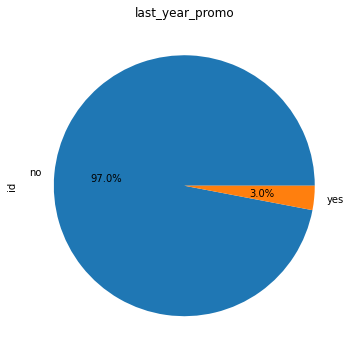

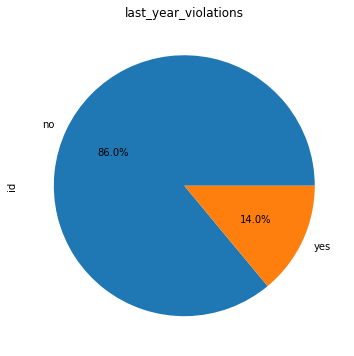

In [24]:
cat_col_names=train_job_satisfaction_rate.select_dtypes(exclude='number').columns.tolist()

for i in cat_col_names:
    train_job_satisfaction_rate.pivot_table(index=i, values='id', aggfunc='count').sort_values(by='id',ascending=False).plot(kind='pie',legend=False,subplots=True,autopct='%1.1f%%')
    plt.title(i)
    plt.show()

В отделе продаж работают 38% сотрудников. Второе место по количеству сотрудников занимает отдел technology - 21% сотрудников. 48% сотрудников на позиции уровня junior,44% - middle,а sinior составляют всего 9%. 52% сотрудников имеют среднюю загруженность. Повышали зарплату всего 3% сотрудников. 14% сотрудников нарушали трудовой договор.

In [25]:
data1=test_target_job_satisfaction_rate_first.merge(test_features_first,on='id',how='inner')

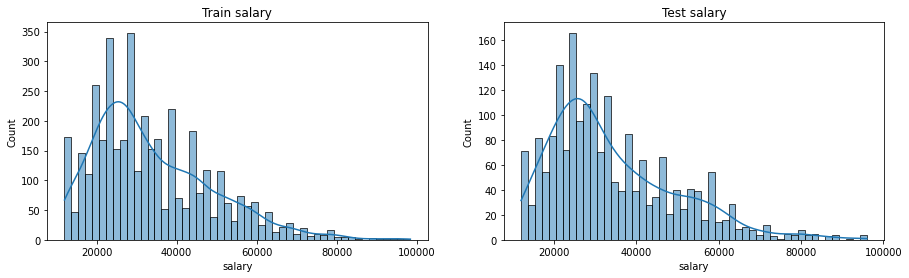

Среднее значение train salary -  33926.7
Среднее значение test salary -  34066.8


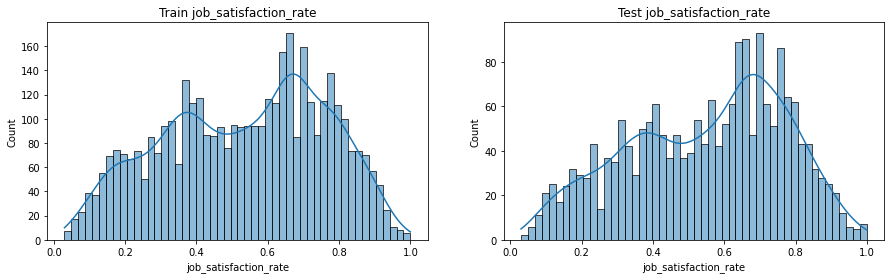

Среднее значение train job_satisfaction_rate -  0.5339950000000001
Среднее значение test job_satisfaction_rate -  0.5487799999999999


In [26]:
cat_col_names=train_job_satisfaction_rate.select_dtypes(include='number').drop(['id','supervisor_evaluation','employment_years'],axis=1).columns.tolist()

for i in cat_col_names:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sb.histplot(data=train_job_satisfaction_rate, x=i, bins=50, kde=True, ax=axs[0])
    sb.histplot(data=data1, x=i, bins=50, kde=True, ax=axs[1])
    axs[0].set_title(f'Train {i}') 
    axs[1].set_title(f'Test {i}') 
    plt.show()
    print(f"Среднее значение train {i} - ",train_job_satisfaction_rate[i].mean())
    print(f"Среднее значение test {i} - ",data1[i].mean())

**По уровню удовлетворенности и зарплате распределения теста и трейна схожи.**

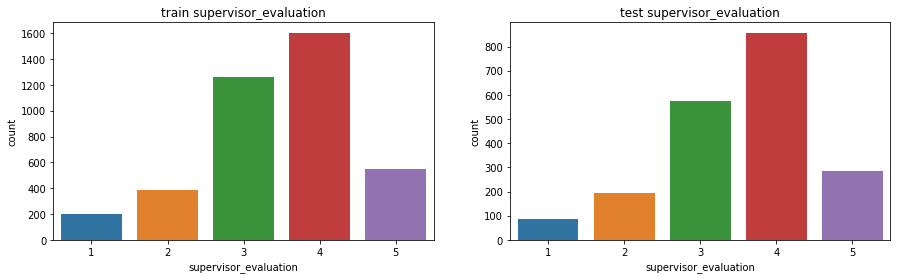

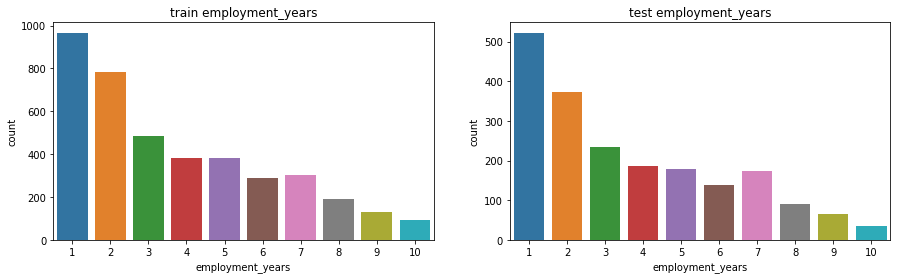

Среднее значение train -  3.7185
Среднее значение test -  3.6665


In [27]:
cat_col_names = train_job_satisfaction_rate[['supervisor_evaluation','employment_years']].columns.tolist()

for i in cat_col_names:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sb.countplot(x=i, data=train_job_satisfaction_rate, ax=axs[0])
    sb.countplot(x=i, data=data1, ax=axs[1])
    axs[0].set_title(f'train {i}') 
    axs[1].set_title(f'test {i}') 
    plt.show()
print(f"Среднее значение train - ", train_job_satisfaction_rate[i].mean())
print(f"Среднее значение test - ", data1[i].mean())


**В части дискретных признаков различий в распределениях тоже нет.**

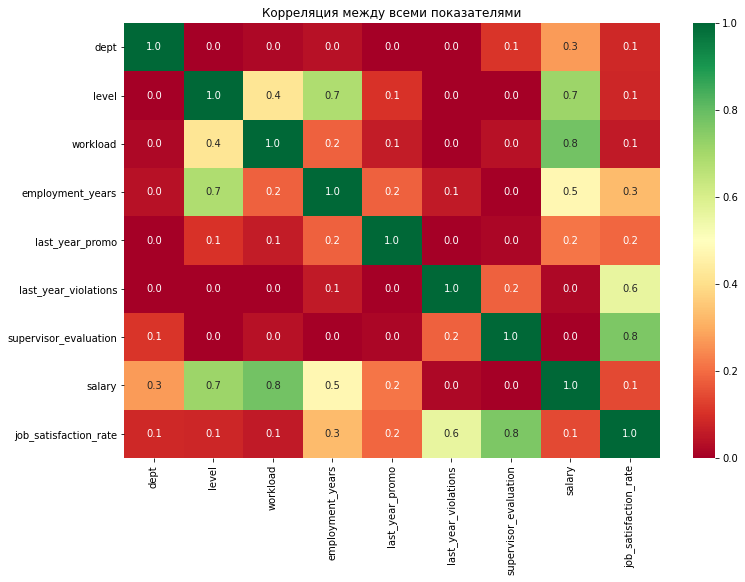

In [28]:
plt.figure(figsize=(12, 8))
sb.heatmap(train_job_satisfaction_rate.drop('id',axis=1) .phik_matrix(interval_cols =['salary','job_satisfaction_rate']), cmap='RdYlGn', vmin=0,vmax=1,annot=True, fmt='.1f')
plt.title("Корреляция между всеми показателями")  
plt.show()

**Категориалные признаки, имеющие ранговый харакетр, необходимо будет закодировать с помощью OrdinalEncoder: level, workload. Категориальный признаки dept, last_year_promo, supervisor_evaluation закодируем с помощью OneHotEncoder, т.к порядок категорий не несет математического смысла. Оптимальный способ масштабирования количественных признаков найдем при поиске оптимальной модели.**

#### **Шаг: Подготовка данных**

Подготовим данные для обучения, при этом перенесем шаги по предобработке в пайплайн.

In [29]:
data=train_job_satisfaction_rate_first

In [30]:
data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [31]:
data1=test_target_job_satisfaction_rate_first.merge(test_features_first,on='id',how='inner')

In [32]:
RANDOM_STATE=42
X_train = data.drop('job_satisfaction_rate', axis=1)
y_train = data['job_satisfaction_rate']

X_test = data1.drop('job_satisfaction_rate', axis=1)
y_test = data1['job_satisfaction_rate']


In [33]:
ohe_columns = [ 
    'dept','last_year_promo','last_year_violations'
]  
ord_columns = [
    'level','workload'
]
num_columns = ['employment_years', 'supervisor_evaluation','salary'] 


In [34]:
replace_space=FunctionTransformer(lambda x: x.replace(' ',np.nan))

In [35]:
ohe_pipe = Pipeline(
    [
        ('replace_space',replace_space),
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [36]:
ord_pipe = Pipeline(
    [
        ('replace_space',replace_space),
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'], 
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [37]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ]
)

In [38]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [39]:
# обучаем модель на тренировочной выборке
pipe_final.fit(X_train, y_train)

# выводим предсказанные значения тренировочной выборки
y_train_pred = pipe_final.predict(X_train)
print(f'Предсказание на обучающей выборке: {y_train_pred}')


Предсказание на обучающей выборке: [0.5        0.76       0.14       ... 0.76       0.51666667 0.175     ]


**В результате был создан пайплайн,включающий этап заполнения пропусков, кодирования категориальных ранговых и неранговых признаков.**

#### **Шаг: Обучение моделей**

Обучим две модели и выберем лучшую модель. За критерий отбора возьмем лучший показатель SMAPE. Сразу подберем гиперпараметры.

In [40]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler()
    ]
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        
        'models__fit_intercept': [
        True, 
        False
    ],
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler()
    ]
    }
] 

Создадим пользовательскую метрику

In [41]:
def custom_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denominator > 0
    smape_values = np.zeros_like(y_true, dtype=float)
    smape_values[mask] = np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]
    return np.mean(smape_values) * 100

    
# создаём пользовательскую метрику
smape = make_scorer(custom_metric,greater_is_better=False) 

In [42]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid = param_grid,
    scoring=smape, 
    cv=5,
    n_jobs=-1,
    error_score='raise'
)
grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('replace_space',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7f06552e3700>)),
                                                                                         ('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=Fa...
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 21),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [LinearRegression()],
                          'models__fit_intercept': [True, False],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [43]:
print('Метрика smape для лучшей модели:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

Метрика smape для лучшей модели:
 -15.012639588554554

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('replace_space',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f06552e3700>)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                            

Чем меньше среднее процентное отклонение, тем лучше. Поэтому метрика выводится отрицательным значением. Проверим показатель smape на тесте.

In [44]:
best_model=grid_search.best_estimator_

In [45]:
X_test['dept'].unique()

array(['technology', 'marketing', 'purchasing', 'hr', 'sales', ' ', nan],
      dtype=object)

In [46]:
X_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [47]:
y_pred = best_model.predict(X_test)

In [48]:
metric = -custom_metric(y_test, y_pred)
print(metric)

-14.284162880579466


#### **Шаг: Оформление выводов**

**Лучшей моделью выбрано Дерево решений с гиперпараметрами глубиной дерева max_depth=13 и масштабированием количественных признаков MinMaxScaler. Итого на тренировочной и тестовой выборках был получен показатель SMAPE ниже 15%. Упрощенно говоря, ошибка составляет примерно 14% от среднего значения, что соответствует критериям отбора модели.**

### **Задача: предсказание увольнения сотрудника из компании**

#### **Шаг: Загрузка данных**

см шаг 1.1

#### **Шаг: Предобработка данных**

см шаг 1.2

#### **Исследовательский анализ данных**

Составим портрет «уволившегося сотрудника». Сравним параметры ушедших сотрудников с теми, кто остался в компании.

In [49]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [50]:
train_quit_yes=train_quit[train_quit['quit']=='yes']
train_quit_no=train_quit[train_quit['quit']=='no']

In [51]:
cat_col_names=train_quit.select_dtypes(include='number').drop(['id','supervisor_evaluation','employment_years'],axis=1).columns.tolist()
cat_col_names

['salary']

23885.11 уволились
37702.23 остались


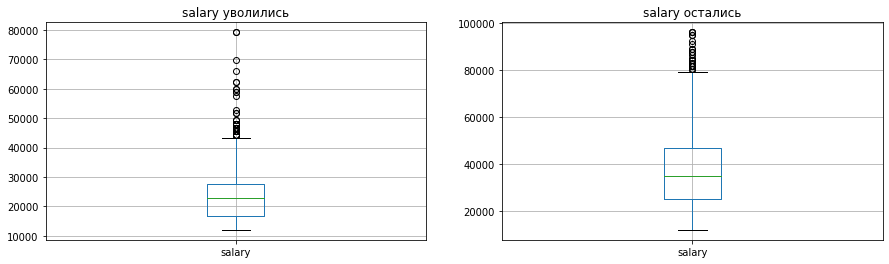

In [52]:
for i in cat_col_names:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    train_quit_yes[[i]].boxplot(ax=axs[0])
    print(round(train_quit_yes[[i]].mean().iloc[0],2),'уволились')
    train_quit_no[[i]].boxplot(ax=axs[1])
    print(round(train_quit_no[[i]].mean().iloc[0],2),'остались')
    axs[0].set_title(f'{i} уволились')
    axs[1].set_title(f'{i} остались')
    plt.show()
    print()
    print()

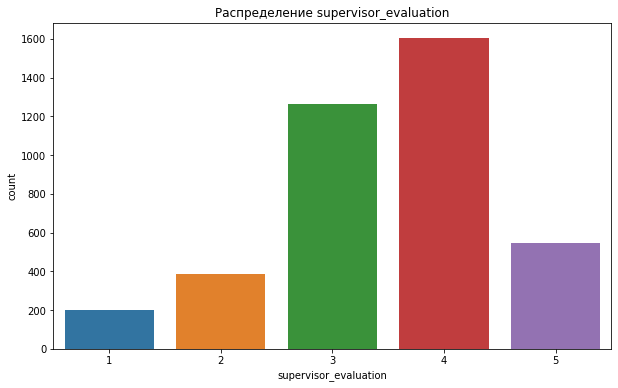

Среднее значение -  3.643105849582173


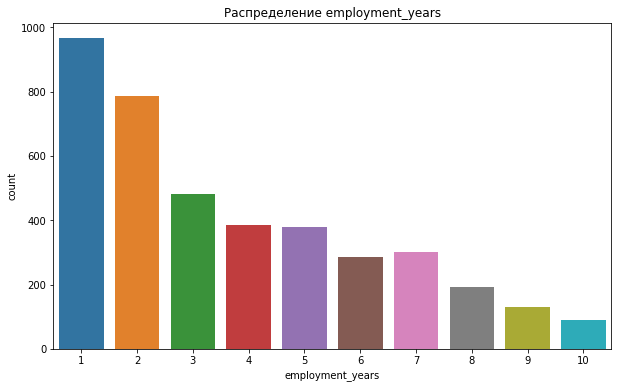

Среднее значение -  4.430710306406685


In [71]:
cat_col_names = train_quit_no[['supervisor_evaluation', 'employment_years']].columns.tolist()

for i in cat_col_names:
    sb.countplot(x=train_job_satisfaction_rate[i])
    plt.title(f'Распределение {i}')
    plt.show()
    print(f"Среднее значение - ", train_quit_no[i].mean())


**В среднем увольняются сотрудники, отработавшие менее 2 лет. Работники со стажем более 2 лет увольняются значительно реже. Оценка руководителем качества работы сотрудников, которые уволились, ниже, чем у тех, кто остался. Средняя оценка уволившихся - 3, оценка оставшихся - 3.6. Зарплата уволившихся значительно ниже,чем у оставшихся - 24 тыс против 38 тыс.**

In [53]:
cat_col_names=train_quit.select_dtypes(exclude='number').drop(['quit'],axis=1).columns.tolist()
cat_col_names

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

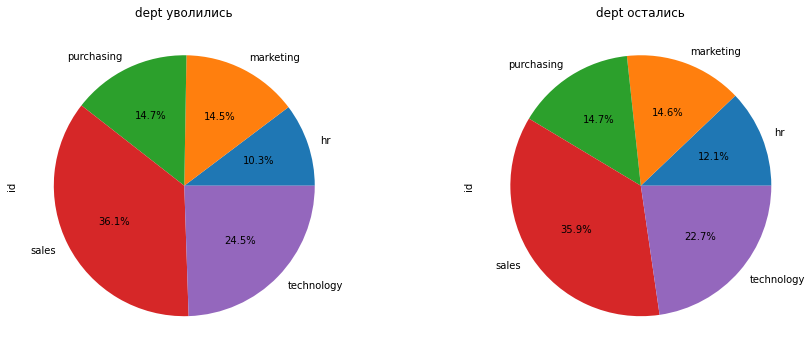

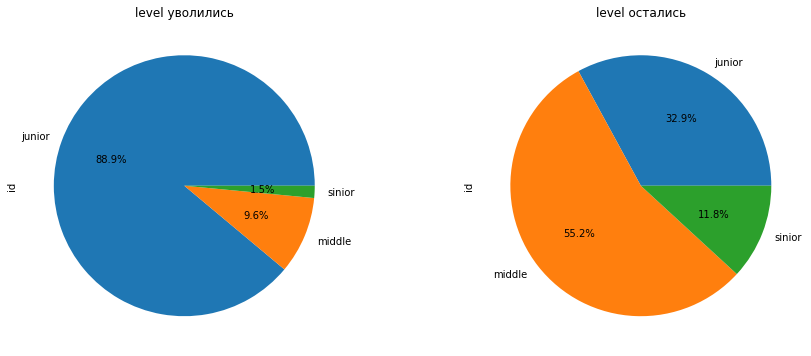

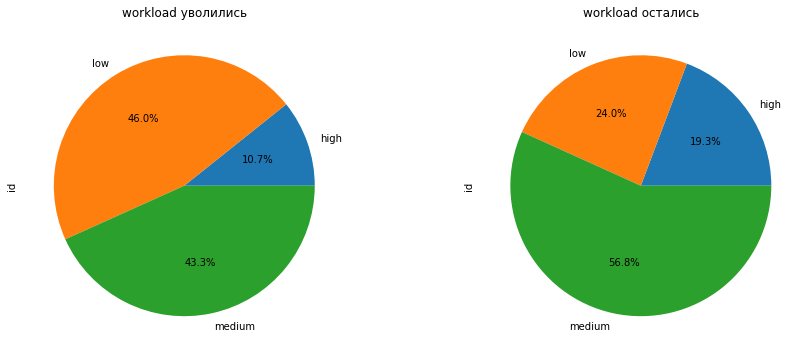

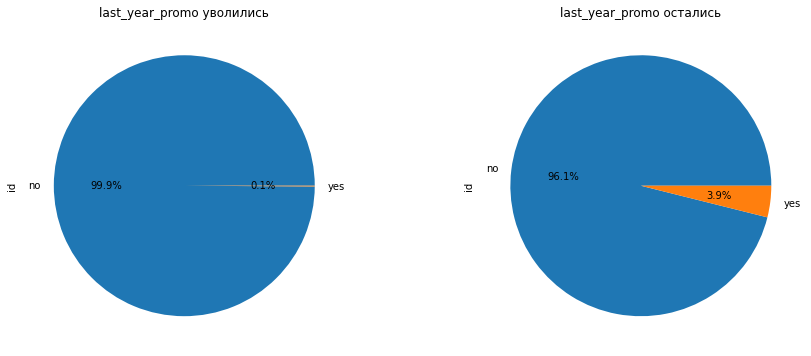

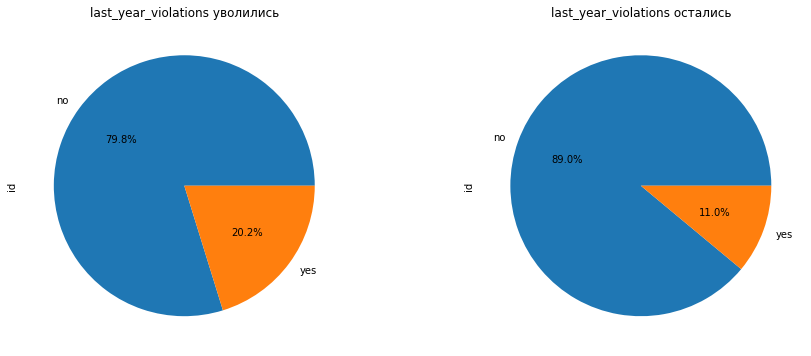

In [54]:
for i in cat_col_names:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    train_quit_yes.pivot_table(index=i, values='id', aggfunc='count').plot(kind='pie',legend=False,subplots=True,autopct='%1.1f%%', ax=axes[0])
    train_quit_no.pivot_table(index=i, values='id', aggfunc='count').plot(kind='pie',legend=False,subplots=True,autopct='%1.1f%%', ax=axes[1])
    axes[0].set_title(f'{i} уволились')
    axes[1].set_title(f'{i} остались')
    plt.show()
    print()
    print()

**Для уволившихся не характерен какой то конкретный отдел - структура по отделам уволившихся и оставшихся не сильно отличается. Увольняются в основном Junior. При этом нагрузка у них как правило низкая, видимо это стажеры. Повышение зарплаты в большинстве происходило у тех, кто остался. Нарушение трудового договора чаще происходимо у тех, кто в результате уволился.**

In [55]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [56]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [57]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [58]:
test_features_sum=test_features.merge(test_target_quit, on='id',how='inner').merge(test_target_job_satisfaction_rate, on='id',how='inner')
test_features_sum.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


0.39 уволились
0.61 остались


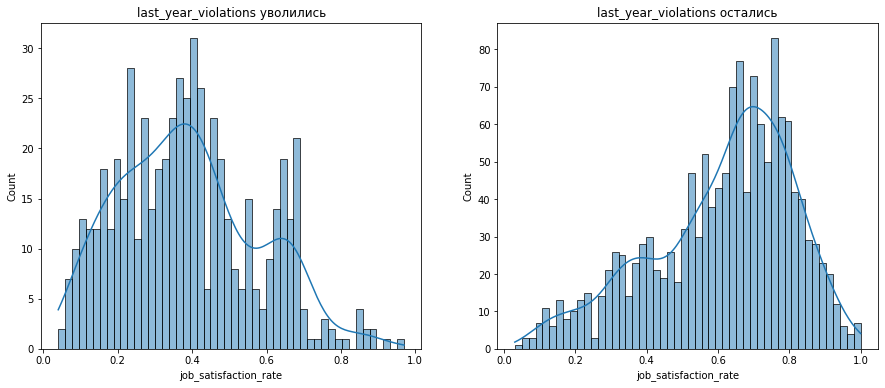

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sb.histplot(data=test_features_sum.query('quit=="yes"'), x='job_satisfaction_rate', bins=50, kde=True, ax=axes[0])
sb.histplot(data=test_features_sum.query('quit=="no"'), x='job_satisfaction_rate', bins=50, kde=True, ax=axes[1])
axes[0].set_title(f'{i} уволились')
axes[1].set_title(f'{i} остались')
print(round(test_features_sum.query('quit=="yes"')[['job_satisfaction_rate']].mean().iloc[0],2),'уволились')
print(round(test_features_sum.query('quit=="no"')[['job_satisfaction_rate']].mean().iloc[0],2),'остались')

plt.show()

**Уровень оценки тех, кто остался 0.61 выше, чем у тех, кто уволился - 0.39.**

#### **Добавление нового входного признака**

Предскажем job_satisfaction_rate на основании имеющихся признаков в train_quit.

In [60]:
test_features_sum.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


In [61]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [62]:
y_pred_train_quit = best_model.predict(train_quit)
y_pred_train_quit=pd.DataFrame(y_pred_train_quit, columns=['job_satisfaction_rate'])
y_pred_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [63]:
train_quit=pd.concat([train_quit, y_pred_train_quit], axis=1)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


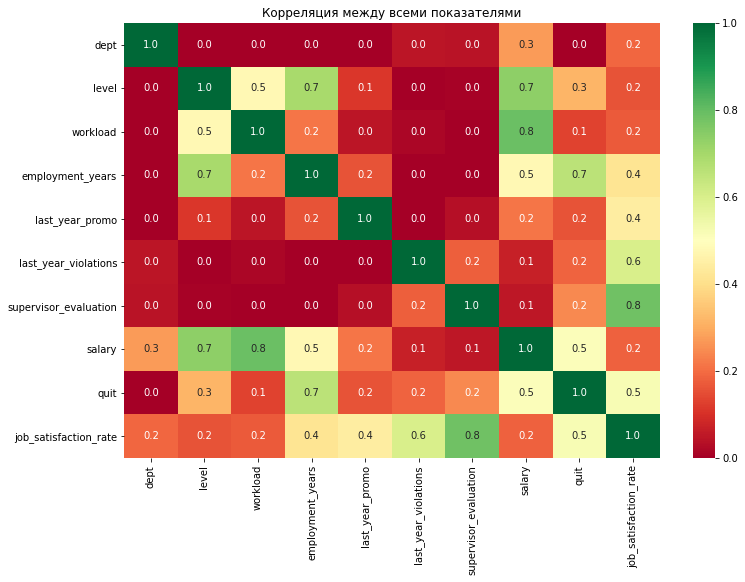

In [67]:
plt.figure(figsize=(12, 8))
sb.heatmap(train_quit.drop('id',axis=1) .phik_matrix(interval_cols =['salary','job_satisfaction_rate']), cmap='RdYlGn', vmin=0,vmax=1,annot=True, fmt='.1f')
plt.title("Корреляция между всеми показателями")  
plt.show()

#### **Шаг: Подготовка данных**

Подготовим данные для обучения, при этом перенесем шаги по предобработке в пайплайн.

In [ ]:
a_data=train_quit

In [ ]:
a_data.head()

In [ ]:
a_data1=test_features_sum

In [ ]:
RANDOM_STATE=42
X_train = a_data.drop('quit', axis=1)
y_train = a_data['quit']

X_test = a_data1.drop('quit', axis=1)
y_test = a_data1['quit']


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test) 

In [ ]:
ohe_columns = [ 
    'dept','last_year_promo','last_year_violations'
]  
ord_columns = [
    'level','workload'
]
num_columns = ['employment_years', 'supervisor_evaluation','salary','job_satisfaction_rate'] 


In [ ]:
replace_space=FunctionTransformer(lambda x: x.replace(' ',np.nan))

In [ ]:
ohe_pipe = Pipeline(
    [
        ('replace_space',replace_space),
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [ ]:
ord_pipe = Pipeline(
    [
        ('replace_space',replace_space),
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'], 
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ]
)

In [ ]:
# итоговый пайплайн: подготовка данных и модель
pipe_final1 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
# обучаем модель на тренировочной выборке
pipe_final1.fit(X_train, y_train)

# выводим предсказанные значения тренировочной выборки
y_train_pred = pipe_final1.predict(X_train)
print(f'Предсказание на обучающей выборке: {y_train_pred}')


**В результате был создан пайплайн,включающий этап заполнения пропусков, кодирования категориальных ранговых и неранговых признаков.**

#### **Шаг: Обучение моделей**

Обучим три модели и выберем лучшую модель. За критерий отбора возьмем лучший показатель ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. Сразу подберем гиперпараметры. 

In [ ]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler()
    ]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler()
    ]
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],

    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler()
    ]
    }
] 

In [ ]:
grid_search = GridSearchCV(
    pipe_final1, 
    param_grid = param_grid,
    scoring='roc_auc', 
    cv=5,
    n_jobs=-1,
    error_score='raise'
)
grid_search.fit(X_train, y_train) 

In [ ]:
print('Метрика smape для лучшей модели:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

In [ ]:
best_model=grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
y_test_pred = grid_search.best_estimator_.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

#### **Шаг: Оформление выводов**

**Лучшей моделью выбран метод k-ближайших соседей c масштабированием количественных признаков StandardScaler. Итого на тренировочной и тестовой выборках был получен показатель ROC-AUC выше 92. Это означает, что при всех значениям порогов классификации вероятности отнесения к тому или иному классу (уволится/не уволится) модель показывает достаточно высокий показатель - 0.92 из 1.**

### **Общие выводы**

В результате проделанной работы были проанализированы, причины, наиболее влияющие на уровень удовлетворенности сотрудником.
В итоге на этот показатель больше всего повлияла оценка качества работы сотрудника, которую дал руководитель. Также выявлено, что признаком неудовлетворенности сотрудника является наружение трудового договора. Стаж работы также является показателем удовлетворенности работой. Сотрудники, давно работающие в компании более долольны работой и имеют более высокую оценку руководителя.

На факт увольнения больше всего оказывает влияние количество отработанных лет. Давно работающие сотрудники реже увольняются. Уровень зарплаты и удовлетворенность работой также оказывают влияние. Видим тот факт, что сотрудник удовлетворен работой и зарплатой в следствие приводит к тому, что он работает долго.

В итоге была построена модель, которая предсказывает уровень удовлетворенности - лучшей моделью стало Дерево решений с гиперпараметрами глубиной дерева max_depth=13 и масштабированием количественных признаков MinMaxScaler. Именно данная модель показала себя лучше, потому что в условиях самой задачи много признаковых составляющих во входных признаках, чем количественных показателей. С такими задачами лучше справляется дерево.

По итогам второй задачи лучшей моделью выбран метод k-ближайших соседей c масштабированием количественных признаков StandardScaler. В данном случае взаимосвязи между объектами менее очевидны, при том данные имеют четкие кластеры.